In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import missingno as mno

import warnings
warnings.filterwarnings('ignore')

In [249]:
data=np.loadtxt('data\Magic.txt')
tmp_columns=list('abcdefghij')
tmp_columns.append('class')
magic=pd.DataFrame(data=data,columns=tmp_columns)

In [250]:
magic.sample(10)

,a,b,c,d,e,f,g,h,i,j,class
5450,0.260647,0.111945,0.582584,0.148540,0.109646,0.527520,0.724928,0.564635,0.012449,0.542211,1.0
660,0.038492,0.058296,0.108279,0.735311,0.630908,0.441709,0.558898,0.570682,0.566966,0.456017,1.0
17480,0.124836,0.052587,0.147812,0.628253,0.429101,0.487383,0.579725,0.546025,0.316892,0.295427,2.0
2204,0.102978,0.042486,0.190627,0.442096,0.328197,0.482879,0.642418,0.506917,0.013830,0.357049,1.0
1125,0.098539,0.077202,0.276020,0.308103,0.227886,0.453026,0.642374,0.486733,0.089871,0.511455,1.0
9136,0.256744,0.120328,0.384684,0.208887,0.166247,0.405223,0.709189,0.467941,0.029008,0.645576,1.0
16398,0.388682,0.226242,0.504287,0.208546,0.168173,0.445570,0.341383,0.576653,0.721443,0.591105,2.0
16231,0.723107,0.198088,0.435512,0.114786,0.096459,0.196294,0.882886,0.427816,0.538407,0.265552,2.0
14217,0.076076,0.042208,0.158930,0.603364,0.462883,0.475179,0.621996,0.562536,0.062751,0.377306,2.0
10500,0.151237,0.117076,0.511561,0.222298,0.163580,0.465460,0.636738,0.478124,0.530333,0.083431,1.0


In [251]:
magic.isnull().sum()

a        0
b        0
c        0
d        0
e        0
f        0
g        0
h        0
i        0
j        0
class    0
dtype: int64

----
# 查看特征之间的相关性

<AxesSubplot:>

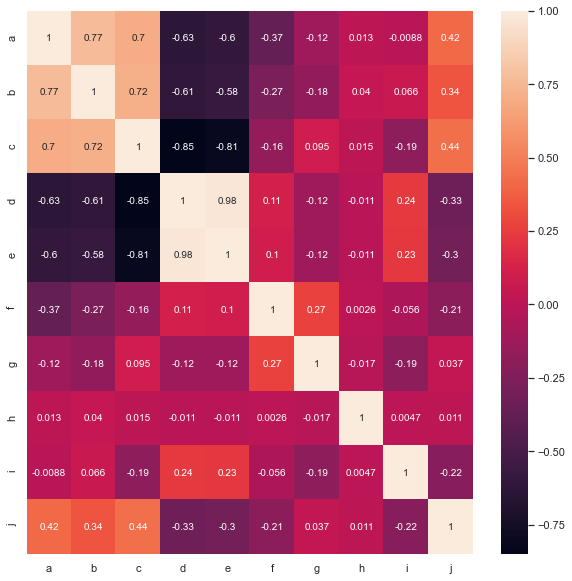

In [252]:
%matplotlib inline
'''
可以看出a-b,a-c,b-c,d-e,j-a,j-b,j-c
'''
complete_features=magic.loc[:,magic.columns.difference(['class'])]
# 绘制热力图
plt.figure(figsize=(10,10))
sns.heatmap(complete_features.corr(),annot=True)


# 选择abc列作为空缺列

<AxesSubplot:>

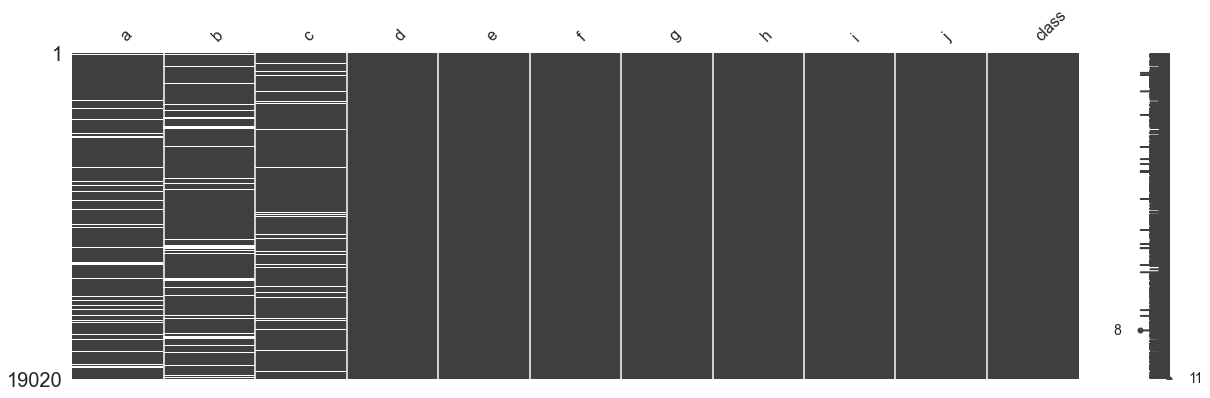

In [253]:
prob_missing = 0.1
col_incomplete=['a','b','c']
ind_incomplete=[magic.columns.get_loc(i) for i in col_incomplete]
df_incomplete = magic.copy()
ix = [(row, col) for row in range(magic.shape[0]) for col in ind_incomplete]
for row, col in random.sample(ix, int(round(prob_missing * len(ix)))):
    df_incomplete.iat[row, col] = np.nan
# 原始的特征列
df_complete=magic[col_incomplete]
df_incomplete_copy=df_incomplete.copy()

df_incomplete.isna().sum()
mno.matrix(df_incomplete, figsize = (20, 6))

# 采用回归的方法来填补空缺值

## random imputation

<AxesSubplot:>

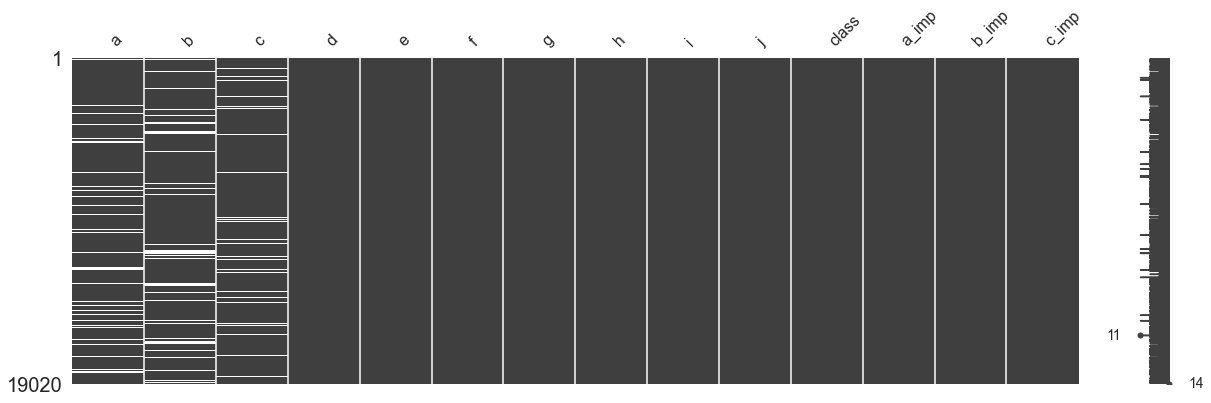

In [254]:
missing_columns=col_incomplete

def random_imputation(df,feature):
    num_missing=df[feature].isnull().sum()
    observed_values=df.loc[df[feature].notnull(),feature]
    df.loc[df[feature].isnull(),feature+'_imp']=np.random.choice(
        observed_values,num_missing,replace=True
    )
    return df

for feature in missing_columns:
    df_incomplete[feature+'_imp']=df_incomplete[feature]
    df_incomplete=random_imputation(df_incomplete,feature)

mno.matrix(df_incomplete,figsize=[20,6])

##  deterministic regression imputation

<AxesSubplot:>

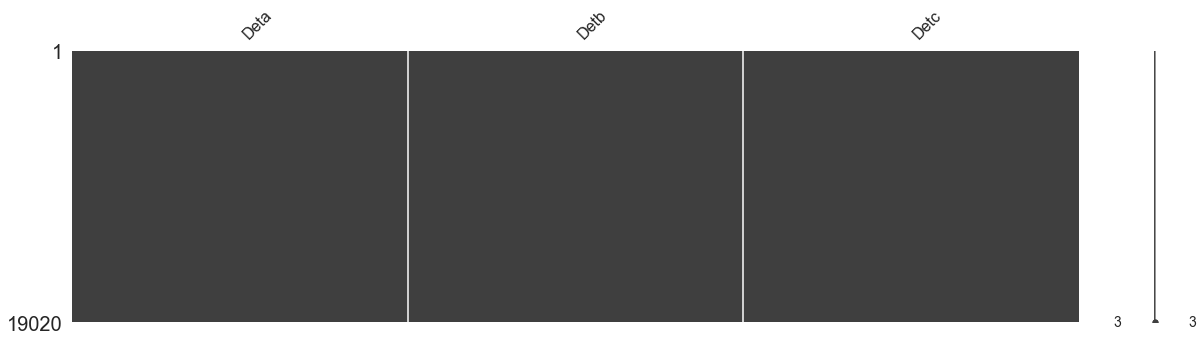

In [255]:
from sklearn.neighbors import KNeighborsRegressor

deter_data=pd.DataFrame(columns=['Det'+name for name in missing_columns])
for feature in missing_columns:
    deter_data['Det'+feature]=df_incomplete[feature+'_imp']
    para=list(set(df_incomplete.columns)-set(missing_columns)-{feature+'_imp'})
    # create model to fit
    model=KNeighborsRegressor()
    model.fit(X=df_incomplete[para],y=df_incomplete[feature+'_imp'])
    deter_data.loc[df_incomplete[feature].isnull(), 'Det'+feature]=model.predict(
        df_incomplete[para]
    )[df_incomplete[feature].isnull()]

mno.matrix(deter_data,figsize=[20,5])

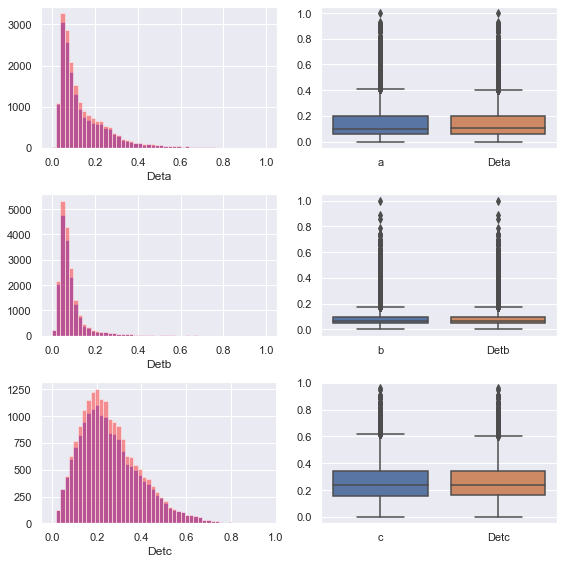

In [256]:
sns.set()
fig,axes=plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(8,8)

for index, variable in enumerate(['a','b','c']):
    sns.distplot(df_incomplete[variable].dropna(),kde=False,ax=axes[index, 0],color='blue')
    sns.distplot(deter_data['Det'+variable],kde=False,ax=axes[index,0],color='red')
    sns.boxplot(data=pd.concat([df_incomplete[variable], deter_data['Det'+variable]],axis=1),ax=axes[index,1])
    plt.tight_layout()

# stochastic regression imputation

In [257]:
random_data=pd.DataFrame(columns=['Ran'+name for name in missing_columns])
for feature in missing_columns:
    random_data['Ran'+feature]=df_incomplete[feature+'_imp']
    para=list(set(df_incomplete.columns)-set(missing_columns)-{feature+'_imp'})
    # create model to fit
    model=KNeighborsRegressor()
    model.fit(X=df_incomplete[para],y=df_incomplete[feature+'_imp'])
    #---
    predict=model.predict(df_incomplete[para])
    std_error=(predict[df_incomplete[feature].notnull()]
        -df_incomplete.loc[df_incomplete[feature].notnull(), feature+'_imp']).std()
    random_predict=np.random.normal(size=df_incomplete[feature].shape[0],
        loc=predict,scale=std_error
    )
    #---
    random_data.loc[(df_incomplete[feature].isnull())&(random_predict>0),
        'Ran'+feature]=random_predict[(df_incomplete[feature].isnull())
        &(random_predict > 0)]

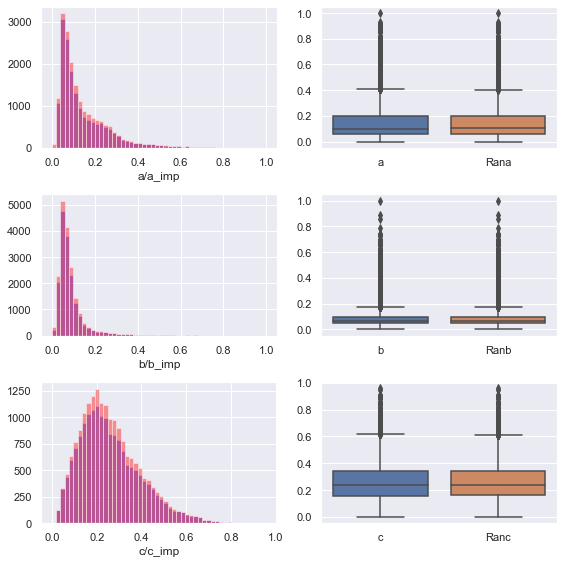

In [258]:
sns.set()
fig,axes=plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(8,8)

for index, variable in enumerate(['a','b','c']):
    sns.distplot(df_incomplete[variable].dropna(),kde=False,ax=axes[index, 0],color='blue')
    sns.distplot(random_data['Ran'+variable],kde=False,ax=axes[index,0],color='red')
    axes[index, 0].set(xlabel=variable+'/'+variable+'_imp')
    sns.boxplot(data=pd.concat([df_incomplete[variable], random_data['Ran'+variable]],axis=1),ax=axes[index,1])

    plt.tight_layout()

In [259]:
df_incomplete[missing_columns]=random_data
df_incomplete.drop(columns=['a_imp','b_imp','c_imp'],axis=1,inplace=True)
df_incomplete.isnull().sum()

a        0
b        0
c        0
d        0
e        0
f        0
g        0
h        0
i        0
j        0
class    0
dtype: int64

## 缺失值填补的数值分析

In [260]:
knn_mse=((df_complete.values-random_data.values)**2).sum()
knn_mse

32.29607335035754

----
# 聚类插补

In [261]:
df_incomplete=df_incomplete_copy.copy()
df_cluster=df_incomplete[df_incomplete.columns.difference(['a','b','c','class'])]
df_cluster

,d,e,f,g,h,i,j
0,0.430390,0.293229,0.470032,0.620576,0.512493,0.445467,0.163066
1,0.587794,0.558601,0.468649,0.623756,0.507944,0.070677,0.412679
2,0.027617,0.027263,0.556215,0.468201,0.416540,0.855111,0.516926
3,0.683714,0.580679,0.469558,0.570630,0.515219,0.116100,0.233582
4,0.345153,0.271003,0.437870,0.632050,0.590373,0.051644,0.718582
...,...,...,...,...,...,...,...
19015,0.650756,0.582457,0.457992,0.602182,0.541215,0.026921,0.213530
19016,0.593249,0.412061,0.479112,0.605095,0.526076,0.964417,0.498046
19017,0.146153,0.080901,0.434164,0.653983,0.509218,0.336652,0.516377
19018,0.092397,0.100756,0.448838,0.417922,0.368263,0.940971,0.823491


##  PCA降维可视化

In [262]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D 

def plot_pca(num,data,label):
    pca=PCA(n_components=num)
    X_pca=pca.fit_transform(data)
    print(pca.components_)
    # 分割数据
    X_failure=np.array([x for i,x in enumerate(X_pca) if label[i]==1.0])
    X_healthy=np.array([x for i,x in enumerate(X_pca) if label[i]==2.0])
    
    if num==3:
        fig = plt.figure(figsize=[10,15])
        ax = Axes3D(fig)   
        #ax.legend(loc='best')
        ax.set_zlabel('Z', fontdict={'size': 15, 'color': 'red'})
        ax.set_ylabel('Y', fontdict={'size': 15, 'color': 'red'})
        ax.set_xlabel('X', fontdict={'size': 15, 'color': 'red'})
        ax.scatter(X_failure[:,0], X_failure[:,1], X_failure[:,2])
        ax.scatter(X_healthy[:,0], X_healthy[:,1], X_healthy[:,2])
        # 调整观察角度
        ax.view_init(elev=50,azim=10)
    elif num==2:
        plt.figure(figsize=[10,10])
        plt.scatter(X_failure[:,0],X_failure[:,1])
        plt.scatter(X_healthy[:,0],X_healthy[:,1])
    else:
        print('i do not want to work.....')


## 手肘法找最佳聚类簇数

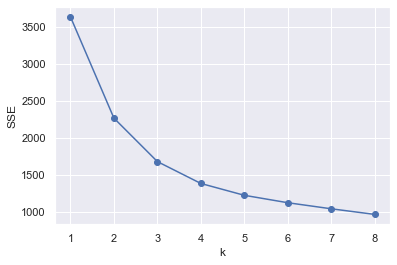

In [263]:
from sklearn.cluster import KMeans
%matplotlib inline
SSE = []  # 存放每次结果的误差平方和
for k in range(1,9):
    estimator=KMeans(n_clusters=k, random_state=9)
    estimator.fit(df_cluster)
    SSE.append(estimator.inertia_) # estimator.inertia_获取聚类准则的总和
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(range(1,9),SSE,'o-')
plt.show()

## 可以看出k=2时曲率最大，故选择聚类的簇数为2

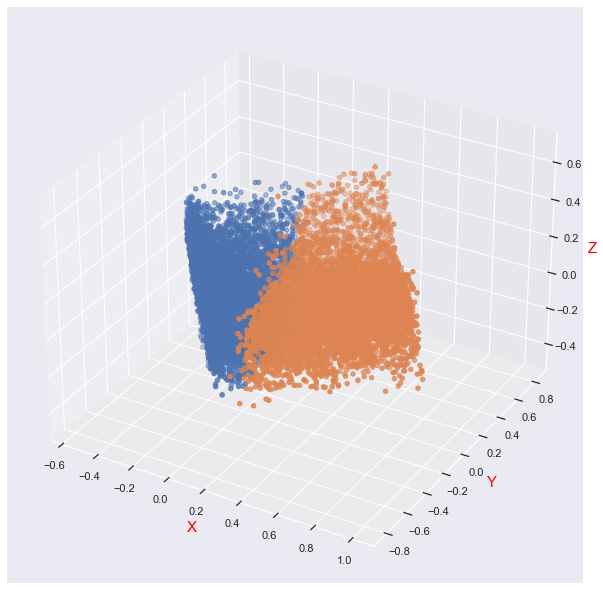

In [264]:
%matplotlib inline
# 先聚类
kmeans = KMeans(n_clusters=2, random_state=9)
idxs = kmeans.fit_predict(df_cluster)
# 降维
pca=PCA(n_components=3)
pca.fit(df_cluster)
X_pca=pca.transform(df_cluster)

subX = []
#遍历cluster，将样本点（像素）按颜色分类装入subX中
for id in range(len(np.unique(idxs))):
    subX.append(np.array([X_pca[i] for i in range(X_pca.shape[0]) if idxs[i] == id]))
    
fig = plt.figure(figsize=[8,8])
ax = Axes3D(fig)    
#ax.legend(loc='best')
ax.set_zlabel('Z', fontdict={'size': 15, 'color': 'red'})
ax.set_ylabel('Y', fontdict={'size': 15, 'color': 'red'})
ax.set_xlabel('X', fontdict={'size': 15, 'color': 'red'})
# ax.view_init(elev=50,azim=10)
    
for x in range(len(subX)):
    newX = subX[x]
    # 绘制散点图
    ax.scatter(newX[:,0], newX[:,1], newX[:,2])


In [265]:
# 计算两个类别的均值（meanA，meanB，meanC） 
df_list=[]
df_data=df_incomplete[df_incomplete.columns.difference(['class'])].values
for id in range(len(np.unique(idxs))):
    tmp_cluster_df=pd.DataFrame([df_data[i] for i in range(df_data.shape[0]) if idxs[i]==id]).iloc[:,:3]
    df_list.append(tmp_cluster_df.mean().values)

In [291]:
# 聚类数据块
cluster_data=pd.DataFrame(columns=['Clu_'+name for name in missing_columns])
# 填补数据
for feature in missing_columns:
    cluster_data['Clu_'+feature]=df_incomplete[feature]
cluster_data['cluster']=idxs

In [292]:
cluster_data

,Clu_a,Clu_b,Clu_c,cluster
0,0.074306,0.062415,0.208043,1
1,0.082815,0.045727,NaN,0
2,0.478241,0.530579,0.626819,1
3,NaN,0.037338,0.117445,0
4,0.214774,0.120603,NaN,0
...,...,...,...,...
19015,0.051838,0.042581,NaN,0
19016,0.074757,0.026141,0.096363,1
19017,0.215712,0.185389,0.445594,0
19018,0.352326,0.299950,0.606919,1


In [293]:
for i,feature in enumerate(missing_columns):
    cluster_data.loc[(cluster_data['Clu_'+feature].isnull())&
        (cluster_data['cluster']==0),'Clu_'+feature]=df_list[0][i]
for i,feature in enumerate(missing_columns):
    cluster_data.loc[(cluster_data['Clu_'+feature].isnull())&
        (cluster_data['cluster']==1),'Clu_'+feature]=df_list[1][i]
cluster_data.drop(['cluster'],axis=1,inplace=True)

In [294]:
cluster_data.isnull().sum()

Clu_a    0
Clu_b    0
Clu_c    0
dtype: int64

In [295]:
cluster_mse=((df_complete.values-cluster_data.values)**2).sum()
cluster_mse

74.81802220522698

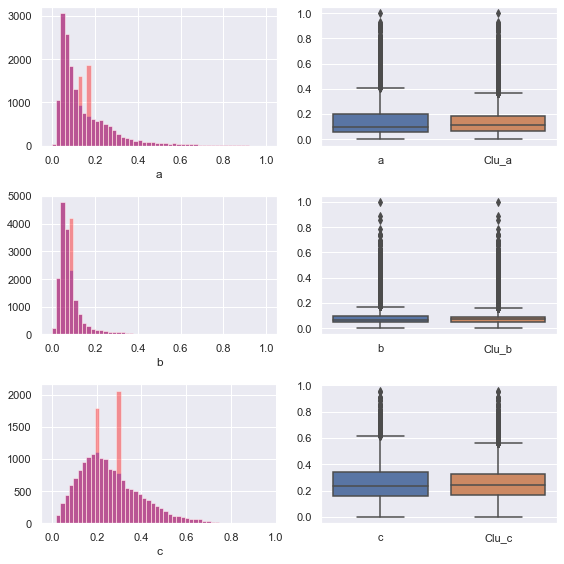

In [303]:
sns.set()
fig,axes=plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(8,8)

for index, variable in enumerate(missing_columns):
    sns.distplot(df_incomplete[variable].dropna(),kde=False,ax=axes[index, 0],color='blue')
    sns.distplot(cluster_data['Clu_'+variable],kde=False,ax=axes[index,0],color='red')
    axes[index, 0].set(xlabel=variable)
    sns.boxplot(data=pd.concat([df_incomplete[variable],cluster_data['Clu_'+variable]],axis=1),ax=axes[index,1])

    plt.tight_layout()

In [180]:
pd.concat([df_incomplete[variable], 
        cluster_data[variable]],axis=1)

,a,a
0,0.074306,0.074306
1,0.082815,0.082815
2,0.478241,0.478241
3,0.059212,0.059212
4,0.214774,0.214774
...,...,...
19015,0.051838,0.051838
19016,0.074757,0.074757
19017,0.215712,0.215712
19018,0.352326,0.352326
